<a href="https://colab.research.google.com/github/nrkfeller/YCBS_notes/blob/master/C8_Deploying_on_ML_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.train import AdamOptimizer
import tensorflow as tf

print(__import__('sys').version)
print(tf.__version__)
print(tf.keras.__version__)

3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0]
1.13.1
2.2.4-tf


In [49]:
!wget https://storage.googleapis.com/nicksdemobucket/wines.csv

--2019-04-21 03:41:30--  https://storage.googleapis.com/nicksdemobucket/wines.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10957 (11K) [application/octet-stream]
Saving to: ‘wines.csv.3’

wines.csv.3         100%[===================>]  10.70K  --.-KB/s    in 0s      

2019-04-21 03:41:30 (65.9 MB/s) - ‘wines.csv.3’ saved [10957/10957]



In [2]:
df = pd.read_csv('wines.csv')
df.head()

,Class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280-OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [3]:
X = df.drop(['Alcohol'], axis=1).values
X.shape

(178, 13)

In [4]:

y = df[['Alcohol']].values
y.shape

(178, 1)

In [0]:
model = Sequential()

model.add(Dense(4, input_shape=(13,), activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error',
                optimizer = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
                metrics=['mean_absolute_error', 'mean_squared_error'])

In [0]:
h = model.fit(X,y, 
              epochs=200,
              batch_size=4,
              steps_per_epoch=int(100/4), 
              validation_split=0.2, 
              verbose=0)

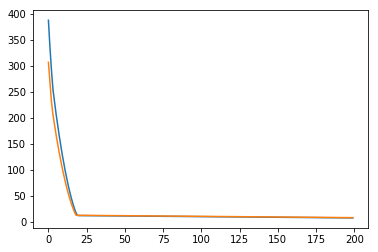

In [22]:
h.history.keys()

import matplotlib.pyplot as plt
plt.plot(h.history['mean_absolute_error'])
plt.plot(h.history['val_mean_absolute_error'])

# Creating Storage and Deploying Model on ML Engine

In [23]:
PROJECT_ID = "gcp-intro-229020" #@param {type:"string"}

# This must absolutely be a GLOBALLY UNIQUE name
BUCKET_NAME = "nickys-ml-demo-bucket" #@param {type:"string"}
REGION = "us-central1" #@param {type:"string"}

! gcloud config set project $PROJECT_ID
! echo $PROJECT_ID

Updated property [core/project].
gcp-intro-229020


In [0]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

In [25]:
# Create Bucket
! gsutil mb -p $PROJECT_ID -l $REGION gs://$BUCKET_NAME
# Display what is in the bucket
!gsutil ls -al gs://$BUCKET_NAME

Creating gs://nickys-ml-demo-bucket/...
ServiceException: 409 Bucket nickys-ml-demo-bucket already exists.
                                 gs://nickys-ml-demo-bucket/keras-job-dir/
                                 gs://nickys-ml-demo-bucket/mcgilldemo/
                                 gs://nickys-ml-demo-bucket/mcgilldemo1/


In [0]:
JOB_DIR = 'gs://' + BUCKET_NAME + '/mcgilldemo'

In [27]:
# Export the model to a local SavedModel directory 
# export_path = tf.contrib.saved_model.save_keras_model(model, 'keras_export')
# print("Model exported to: ", export_path)

# Export the model to a SavedModel directory in Cloud Storage
export_path = tf.contrib.saved_model.save_keras_model(model, JOB_DIR + '/keras_export')
print("Model exported to: ", export_path)


Consider using a TensorFlow optimizer from `tf.train`.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: gs://nickys-ml-demo-bucket/mcgilldemo/keras_export/1555819132/saved_model.pb
Model exported to:  b'gs://nickys-ml-demo-bucket/mcgilldemo/keras_export/1555819132'


In [28]:
MODEL_NAME = "mcgilldemo"

! gcloud ml-engine models create $MODEL_NAME \
  --regions $REGION

ERROR: (gcloud.ml-engine.models.create) Resource in project [gcp-intro-229020] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name


In [29]:
MODEL_VERSION = "v1"

# Get a list of directories in the `keras_export` parent directory
KERAS_EXPORT_DIRS = ! gsutil ls $JOB_DIR/keras_export/

# Pick the directory with the latest timestamp, in case you've trained
# multiple times
SAVED_MODEL_PATH = KERAS_EXPORT_DIRS[-1]

# Create model version based on that SavedModel directory
! gcloud ml-engine versions create $MODEL_VERSION \
  --model $MODEL_NAME \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin $SAVED_MODEL_PATH

ERROR: (gcloud.ml-engine.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


In [30]:
X[0]

array([1.000e+00, 1.710e+00, 2.430e+00, 1.560e+01, 1.270e+02, 2.800e+00,
       3.060e+00, 2.800e-01, 2.290e+00, 5.640e+00, 1.040e+00, 3.920e+00,
       1.065e+03])

In [31]:
%%bash
rm prediction_input.json
touch prediction_input.json
echo "[1.0, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0]" >> prediction_input.json
cat prediction_input.json

[1.0, 1.71, 2.43, 15.6, 127.0, 2.8, 3.06, 0.28, 2.29, 5.64, 1.04, 3.92, 1065.0]


In [32]:
! gcloud ml-engine predict \
  --model $MODEL_NAME \
  --version $MODEL_VERSION \
  --json-instances prediction_input.json

DENSE_1
[16.67540168762207]


In [0]:
# Delete model
! gcloud ml-engine versions delete v1 --quiet --model mcgilldemo

! gcloud ml-engine models delete mcgilldemo --quiet